---
#  Explanatory Analysis with UBER's Data

##### The aim of this project is to explore this [dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) from 2014 September through 2015 August and find out interesting information through explanatory analysis with Python
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import seaborn as sns
import datetime
import time 
%matplotlib inline

In [2]:
df = pd.read_csv('UBER.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 6 columns):
id                 int64
origin_taz         object
destination_taz    object
pickup_datetime    object
trip_distance      float64
trip_duration      object
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ GB


In [4]:
df.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
0,252581,7C,6A,2014-09-01 09:00:00,4.25,0:15:11
1,252582,7B,15,2014-09-01 18:00:00,10.17,0:34:05
2,252583,11,2A,2014-09-01 17:00:00,4.02,0:17:06
3,252584,3B,4A,2014-09-01 13:00:00,1.46,0:06:32
4,252585,2A,10,2014-09-01 14:00:00,8.31,0:26:17


In [5]:
#Check for missing data within each column
df.isnull().sum()

id                       0
origin_taz               0
destination_taz    1273023
pickup_datetime          0
trip_distance           38
trip_duration           38
dtype: int64

In [6]:
#Check how many unique IDs we have in the dataset
len(df.id.unique()) #~3.1million

30925738

In [7]:
#How many different origin_taz do we have?
len(df.origin_taz.unique())

28

In [8]:
#How many different destination_taz do we have?
len(df.destination_taz.unique())

30

In [9]:
#Checking if null values in the columns are the same for both trip distance and trip duration
check = (df[df.trip_distance.isnull() & df.trip_duration.isnull()])
len(check) #~ Indeed it is!

38

In [10]:
check.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15155317,39535,2A,11,2015-04-25 12:00:00,NaN,NaN
15245057,1009076,2A,2A,2015-04-26 01:00:00,NaN,NaN
16519652,15028665,2A,7C,2015-04-29 21:00:00,NaN,NaN
17148253,22250173,2A,2A,2015-04-12 02:00:00,NaN,NaN
17297563,23716998,2C,11,2015-04-25 13:00:00,NaN,NaN


In [11]:
#We convert the string pickup_datetime column to an actual datetime format
df['pickup_dt'] = pd.to_datetime(df['pickup_datetime'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 7 columns):
id                 int64
origin_taz         object
destination_taz    object
pickup_datetime    object
trip_distance      float64
trip_duration      object
pickup_dt          datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.6+ GB


In [13]:
#We break down the dates to the years, months, days, and hours for further analysis later on
df['year'] = df['pickup_dt'].dt.year
df['month'] = df['pickup_dt'].dt.month
df['day'] = df['pickup_dt'].dt.day
df['hour'] = df['pickup_dt'].dt.hour
df['day_of_week'] = df['pickup_dt'].dt.dayofweek

### In order to deal with the 38 missing values from the trip_duration and trip_distance, we attempt to replace those null values with the mean distance and duration w.r.t to the trip origin

In [14]:
#First, we need a function to convert duration to an integer time
def convertDuration(m):
    if pd.isnull(m):
        val = 0 #fills null with 0
    else:
        hms = m.split(':')
        val = int(hms[0])*60 + int(hms[1]) + int(hms[2])/60.0
    return val

In [15]:
df['int_duration'] = df.trip_duration.apply(convertDuration)

In [16]:
df_meanDistTime = df.groupby(['origin_taz', 'destination_taz'])[['trip_distance', 'int_duration']].mean()
df_meanDistTime.head()

trip_distance  int_duration
origin_taz destination_taz                             
1          1                     1.421855     10.565513
           10                    3.650791     17.977578
           11                    5.093679     22.489925
           12                    8.887789     29.102406
           13                   11.583137     32.156759

In [17]:
for i in check.index:
    orig = df.loc[i, 'origin_taz']
    dest = df.loc[i, 'destination_taz']
    df.loc[i, 'trip_distance'] = df_meanDistTime.loc[orig, dest].trip_distance
    df.loc[i, 'int_duration'] = df_meanDistTime.loc[orig, dest].int_duration

# Data Visualizations! 
##### We filter out data that are more than 14 hours long

In [18]:
#178 trips that are more than 14 hours
len(df[(df.int_duration > 840)])

178

In [19]:
#Get rid of data points that represent the zeroth hour of Sep 2015 so that we can have 
#exactly 365 days
len(df[df.pickup_dt == datetime.date(2015, 9, 1)])

1852

In [20]:
df_plot = df[(df.pickup_dt != datetime.date(2015, 9, 1)) & (df.int_duration <= 840)].copy()

In [21]:
df_plot[['int_duration', 'trip_distance']].describe()

,int_duration,trip_distance
count,3.092371e+07,3.092371e+07
mean,2.099075e+01,5.199601e+00
std,1.604234e+01,6.130603e+00
min,0.000000e+00,0.000000e+00
25%,1.085000e+01,1.690000e+00
50%,1.723333e+01,3.090000e+00
75%,2.668333e+01,6.230000e+00
max,8.394667e+02,5.685700e+02


In [22]:
month_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
wkday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

## Can we find anything interesting by looking at median distance travelled during a givenday?

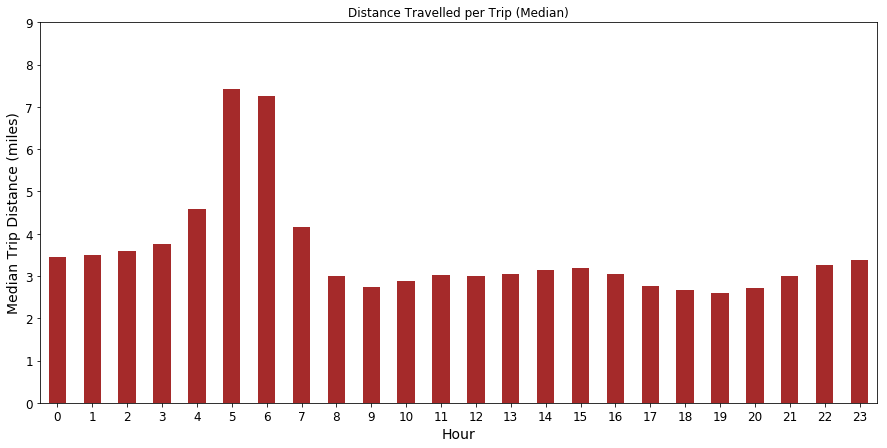

In [23]:
plt.style.use('seaborn-pastel')
plt.figure(figsize = (15,7))


df_plot[df_plot.day_of_week >= 0].groupby('hour')['trip_distance'].median().plot(kind='bar', 
                        rot = 0, fontsize=18, title = 'Distance Travelled per Trip (Median)',
                        color='brown')
plt.ylim(0, 9)
plt.tick_params(labelsize=12)
plt.ylabel('Median Trip Distance (miles)', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.show()

#### An interesting trend emerges when we see that the median trip distance is highest after 4am and just before 8am. Perhaps this is the time when go to work? 

## Which day of the week has the highest median travelling duration?

In [24]:
df_dur = df_plot.groupby('day_of_week')['int_duration'].median() 

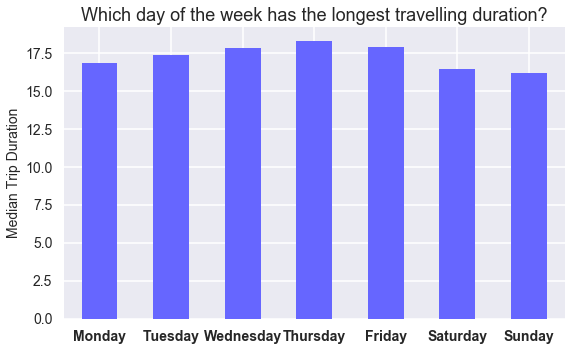

In [38]:
plt.style.use('seaborn-pastel')

ax = df_dur.plot(kind='bar', rot = 0, figsize = (8,5), fontsize = 12, color='#6666ff')
ax.set_xticklabels(wkday_labels, weight='bold')

plt.xlabel('')
plt.ylabel('Median Trip Duration', fontsize = 14)
plt.tick_params(labelsize=14)
plt.title('Which day of the week has the longest travelling duration?', fontsize = 18)

plt.show()

## Distributions for trip distance and trip duration

In [26]:
#Create function for formatting millions on axis. Returns millions with one decimal.
def mil_format(x, tick_pos):
    return '{:.1f}{}'.format(x * 1e-6, 'M')

In [27]:
freq, dist_bins = np.histogram(df_plot.trip_distance, bins=10, range=(0, 25))

In [28]:
freq, time_bins = np.histogram(df_plot.int_duration, bins=10, range=(0, 50))

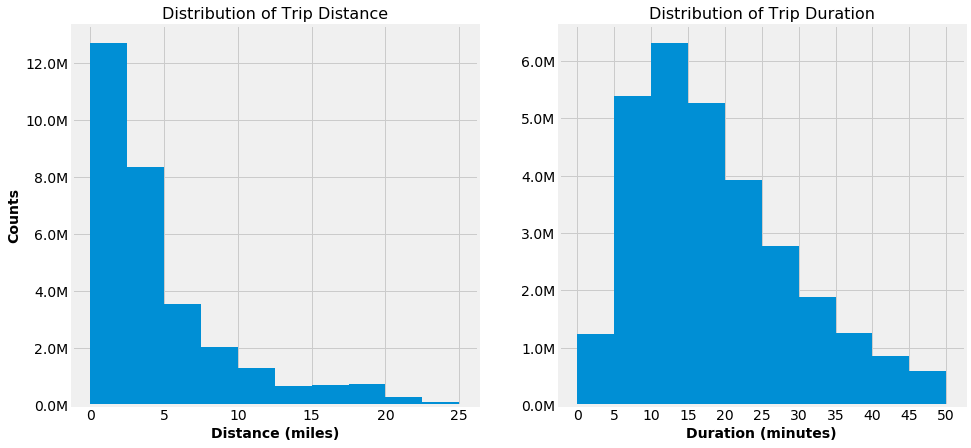

In [29]:
#Here we plot the distribution of trip duration next to the histogram of trip distance for comparison.
fig = plt.figure(figsize=(16,7))
plt.style.use('fivethirtyeight')

formatter = FuncFormatter(mil_format)

plt.subplot(1,2,1)
ax1 = df_plot.trip_distance.dropna().hist(bins=dist_bins)
ax1.yaxis.set_major_formatter(formatter)

plt.xlabel('Distance (miles)', fontsize=14, weight='bold')
plt.ylabel('Counts', fontsize=14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Distance', fontsize=16)

plt.subplot(1,2,2)
ax2 = df_plot.int_duration.hist(bins=time_bins)
ax2.yaxis.set_major_formatter(formatter)
ax2.set_xticks(time_bins) 

plt.xlabel('Duration (minutes)', fontsize=14, weight='bold')
plt.ylabel('')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Duration', fontsize=16)

plt.show()

### Let's see what are the most popular UBER pick up and drop off locations!

In [30]:
count_Origin = df_plot.origin_taz.value_counts
count_Dest = df_plot.destination_taz.value_counts

In [31]:
print('The top 10 pick up locations account for ', 
      count_Origin().head(10).sum()/(len(df_plot))*100,'% of all pick up locations')
print('The top 10 drop up locations account for ',
      count_Dest().head(10).sum()/(len(df_plot))*100, '% of all drop up locations')

The top 10 pick up locations account for  66.6926262529707 % of all pick up locations
The top 10 drop up locations account for  61.71937078179628 % of all drop up locations


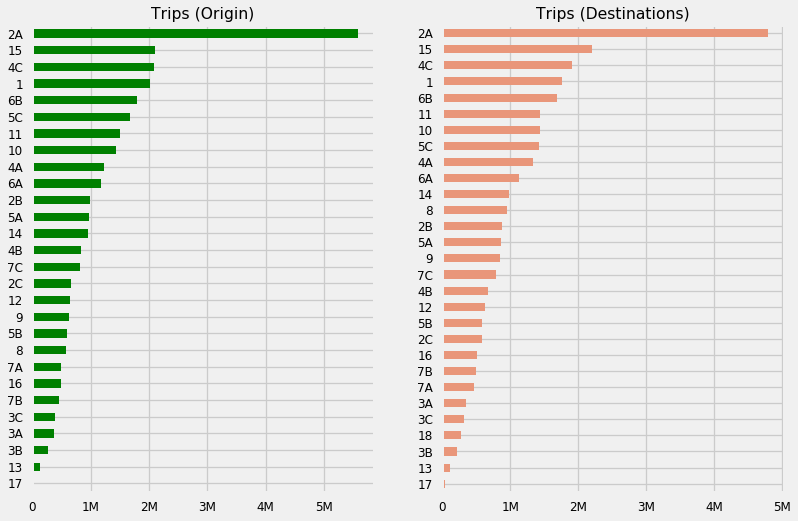

In [32]:
fig = plt.figure(figsize = (12,8))
plt.style.use('seaborn-talk')
plt.subplot(1,2,1)
ax1 = count_Origin(ascending=True).plot(kind = 'barh', color='green', title ='Trips (Origin)')
ax1.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])
plt.tick_params(labelsize=12)


plt.subplot(1,2,2) 
ax2 = count_Dest(ascending=True).plot(kind = 'barh', color='darksalmon', title = 'Trips (Destinations)')
ax2.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])
plt.tick_params(labelsize=12)

plt.show()

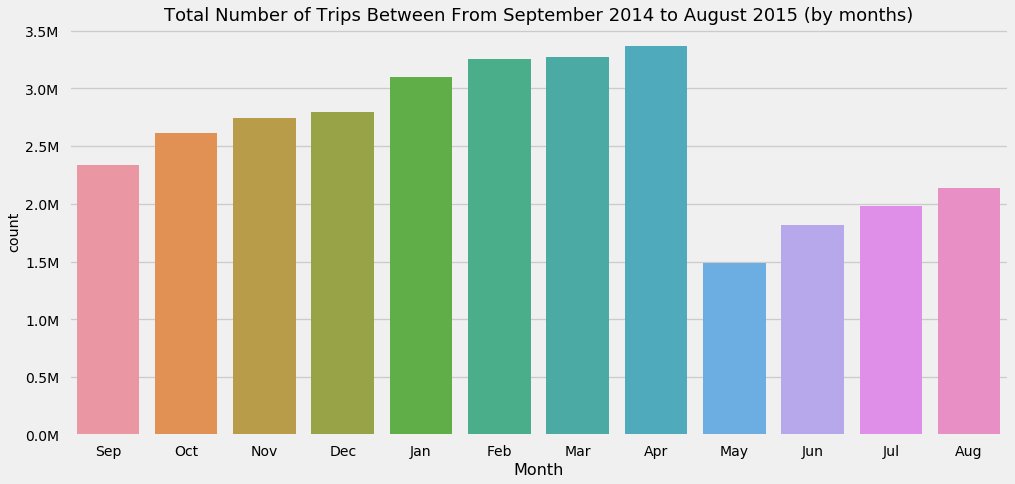

In [33]:
fig = plt.figure(figsize = (15,7))
plt.title('Total Number of Trips Between From September 2014 to August 2015 (by months)',
          fontsize=18)
ax2 = sns.countplot(df_plot.month)
ax2.set_xticklabels(month_labels)
ax2.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=14)
plt.xlabel('Month', fontsize=16)

plt.show()

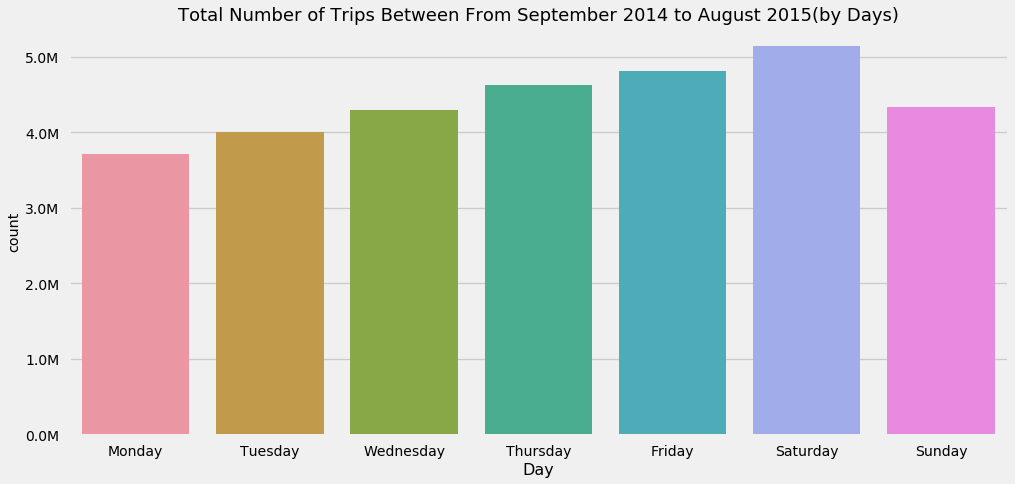

In [34]:
fig = plt.figure(figsize = (15,7))
plt.title('Total Number of Trips Between From September 2014 to August 2015(by Days)',
          fontsize=18)
ax2 = sns.countplot(df_plot.day_of_week, order = range(7))
ax2.set_xticklabels(wkday_labels)
ax2.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=14)
plt.xlabel('Day', fontsize=16)

plt.show()

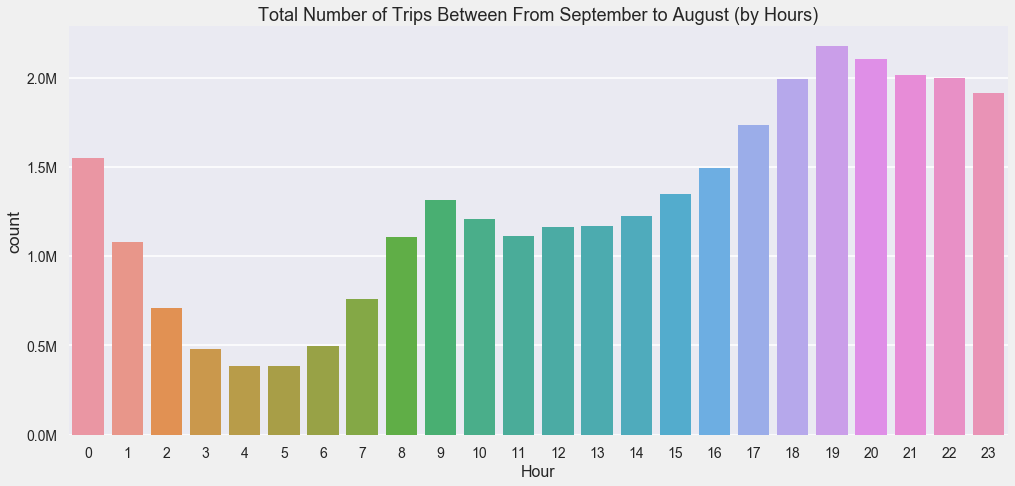

In [35]:
# Create plots comparing demand per different time categories:
formatter = FuncFormatter(mil_format)
fig = plt.figure(figsize = (15,7))
sns.set_style("darkgrid")
sns.set_context("poster")
ax1 = sns.countplot(df_plot.hour, order = range(24))
plt.title('Total Number of Trips Between From September to August (by Hours)', fontsize=18)
ax1.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=14)
plt.xlabel('Hour', fontsize=16)

plt.show()

## Most popular pick up & drop off pairs

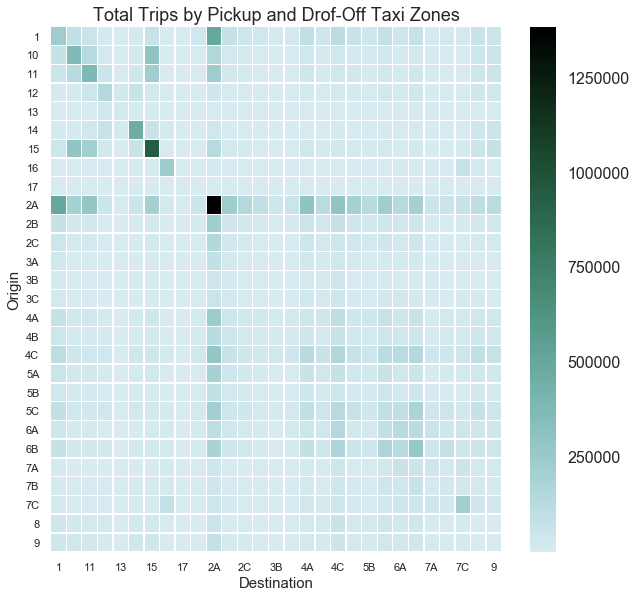

In [36]:
#Defining the data 
df_pvttab = df_plot.pivot_table('id', aggfunc='count', index='origin_taz', columns='destination_taz')

#Visualize the origin versus destination matrix via a heatmap:
fig = plt.figure(figsize=(9,9))

cmap = sns.cubehelix_palette(10, start=2, rot=0.2, dark=0, light=.9, as_cmap=True) 

sns.heatmap(df_pvttab, cmap=cmap, linewidths=0.3, cbar=True)

plt.title('Total Trips by Pickup and Drof-Off Uber Zones', fontsize=18)
plt.xlabel('Destination', fontsize=15)
plt.ylabel('Origin', fontsize=15)
plt.tick_params(labelsize=11)
plt.show()